# 

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import collections
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch

import sys
sys.path.append("../src")
import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from PIL import Image
from sklearn.metrics import DistanceMetric, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi
import clip
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import adjusted_mutual_info_score, v_measure_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")
from collections import defaultdict
warnings.filterwarnings("ignore", category=ConvergenceWarning)


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [3]:
# df = pd.read_csv('../data/fitzpatrick17k/fitzpatrick-mod.csv')

# classes = sorted(df.label.unique())
# three_classes = sorted(df.three_partition_label.unique())
# nine_classes = sorted(df.nine_partition_label.unique())
# class_map = dict(zip(classes, range(len(classes))))
# three_class_map = dict(zip(three_classes, range(len(three_classes))))
# nine_class_map = dict(zip(nine_classes, range(len(nine_classes))))

# images = list(Path('../data/fitzpatrick17k/images/').glob('*.jpg'))

# model, preprocess = clip.load("ViT-B/32", device='cuda')

# embeddings = []
# labels = {}
# for i, image in tqdm(enumerate(images), total=len(images)):
#     row = df.query(f"md5hash == '{image.stem}'")
#     label = class_map[row.label.values[0]]
#     three_label = three_class_map[row.three_partition_label.values[0]]
#     nine_label = nine_class_map[row.nine_partition_label.values[0]]
#     labels[i] = {
#         'label': label,
#         'three_label': three_label,
#         'nine_label': nine_label,
#         'fitzpatrick': row.aggregated_fitzpatrick_scale.values[0],
#     }
#     # img = Image.open(image)
#     # with torch.inference_mode():
#     #     embedding = model.encode_image(preprocess(img)[None].to('cuda'))
#     # embeddings.append(embedding.cpu())

# # X = torch.cat(embeddings)
# # y = torch.tensor([v['nine_label'] for v in labels.values()])
# # y = torch.tensor([v['three_label'] for v in labels.values()])
# y = torch.tensor([v['label'] for v in labels.values()])
# # y = torch.tensor([v['fitzpatrick'] for v in labels.values()])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# km = KMeans(n_clusters=114, random_state=0, n_init="auto").fit(X_train)

# fitz = torch.load('../data/fitzpatrick17k/fitzpatrick_embeddings_clip.pt')

# fitz['labels'].shape

In [7]:
pwd

'/u/luchar/data-valuation/nbs'

In [124]:
saved_embedding_path = Path("../embeddings")

clean_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
}

noise_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224_noise.pt"
    ),
#     "breastmnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_breastmnist_noise_224.pt"
#     ),
#     "chestmnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_chestmnist_noise_224.pt"
#     ),
#     "dermamnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_dermamnist_noise_224.pt"
#     ),
#     "pathmnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_pathmnist_noise_224.pt"
#     ),
#     "retinamnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_retinamnist_noise_224.pt"
#     ),
#     "tissuemnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_tissuemnist_noise_224.pt"
#     ),
#     "organamnist": torch.load(
#         saved_embedding_path / "clip_embedding_medmnist_organamnist_noise_224.pt"
#     ),
}

In [127]:
cifar = torch.load(saved_embedding_path / "clip_embedding_cifar_seller.pt")
fashion = torch.load(saved_embedding_path / "clip_embedding_fashion_seller.pt")
mnist = torch.load(saved_embedding_path / "clip_embedding_mnist_seller.pt")

In [128]:
med = torch.cat([v['embeddings'][:int(10000/5)] for k, v in clean_med.items() if k not in ('breastmnist', )])
med = med[torch.randperm(med.size(0))]

In [129]:
def interpolate(a, b, num_samples=10000, num_parts=10):
    n = int(min(len(a), len(b), num_samples) / num_parts)
    # for j in range(1, num_parts + 1):
    #     print(n * j, (num_parts - j) * n)
    ret = {j: torch.cat([b[: n * j], a[: n * (num_parts - j)]]) for j in range(1, num_parts + 1)}
    return ret
    
m = interpolate(
    clean_med['dermamnist']['embeddings'],
    cifar['images'] [:10000]
)
# m[4].shape

In [196]:
num_buyer = 100
num_seller = 10000

buyer = 'bloodmnist'
# buyer = 'chestmnist'
# buyer = 'pathmnist'
# buyer = 'tissuemnist'
# buyer = 'dermamnist'
# buyer = 'organamnist'
# buyer = 'retinamnist'
# buyer_data = clean_med['bloodmnist']['embeddings'][-num_seller:]
# buyer_data = clean_med['chestmnist']['embeddings'][-num_seller:]
buyer_data = clean_med[buyer]['embeddings'][-num_seller:]


sellers = {}
# for k, v in interpolate(clean_med[buyer]["embeddings"][:num_seller], noise_med[buyer]["embeddings"][:num_seller]).items():
#     sellers[f'{20 * k}% Noisy {buyer.capitalize()}'] = v

num_parts = 10
parts = 100 // num_parts
    
for k, v in interpolate(clean_med[buyer]["embeddings"][:num_seller], med[:num_seller], num_parts = num_parts).items():
    sellers[f'{parts * k}% MedMNIST'] = v

for k, v in interpolate(clean_med[buyer]["embeddings"][:num_seller], mnist["images"][:num_seller], num_parts = num_parts).items():
    sellers[f'{parts * k}% MNIST'] = v
    
for k, v in interpolate(clean_med[buyer]["embeddings"][:num_seller], cifar["images"][:num_seller], num_parts = num_parts).items():
    sellers[f'{parts * k}% CIFAR'] = v

# sellers["BloodMNIST"] = clean_med['bloodmnist']["embeddings"][:num_seller]
# sellers["ChestMNIST"] = clean_med['chestmnist']["embeddings"][:num_seller]
# sellers[buyer.capitalize()] = clean_med[buyer]["embeddings"][:num_seller]
    
reload(valuation)

seller_values = {
    k: valuation.get_value(
        buyer_data,
        v,
        # cifar['images'][-100:], v,
        n_components=10,
        # normalize=True,
        use_neg_components=True,
        # use_dp=True,
        # dp_epsilon=0.1,
        # dp_delta=1e6,
    )
    for k, v in tqdm(sellers.items())
}

  0%|          | 0/30 [00:00<?, ?it/s]

In [197]:
num = num_parts
num += 1
# cmap1 = plt.cm.inferno
# cmap1 = cmap1(np.linspace(0.1, 1, 10))
# cmap2 = plt.cm.viridis
# cmap2 = cmap2(np.linspace(0.1, 1, 10))
# cmap3 = plt.cm.cividis
# cmap3 = cmap3(np.linspace(0.1, 1, 10))

rang = np.linspace(0, 1, num)[::-1]
greens = plt.cm.YlGn(rang)
viridis = plt.cm.viridis(rang)
cividis = plt.cm.cividis(rang)
plasma = plt.cm.inferno(rang)
magma = plt.cm.inferno(rang)

10% MedMNIST
20% MedMNIST
30% MedMNIST
40% MedMNIST
50% MedMNIST
60% MedMNIST
70% MedMNIST
80% MedMNIST
90% MedMNIST
100% MedMNIST
10% MNIST
20% MNIST
30% MNIST
40% MNIST
50% MNIST
60% MNIST
70% MNIST
80% MNIST
90% MNIST
100% MNIST
10% CIFAR
20% CIFAR
30% CIFAR
40% CIFAR
50% CIFAR
60% CIFAR
70% CIFAR
80% CIFAR
90% CIFAR
100% CIFAR


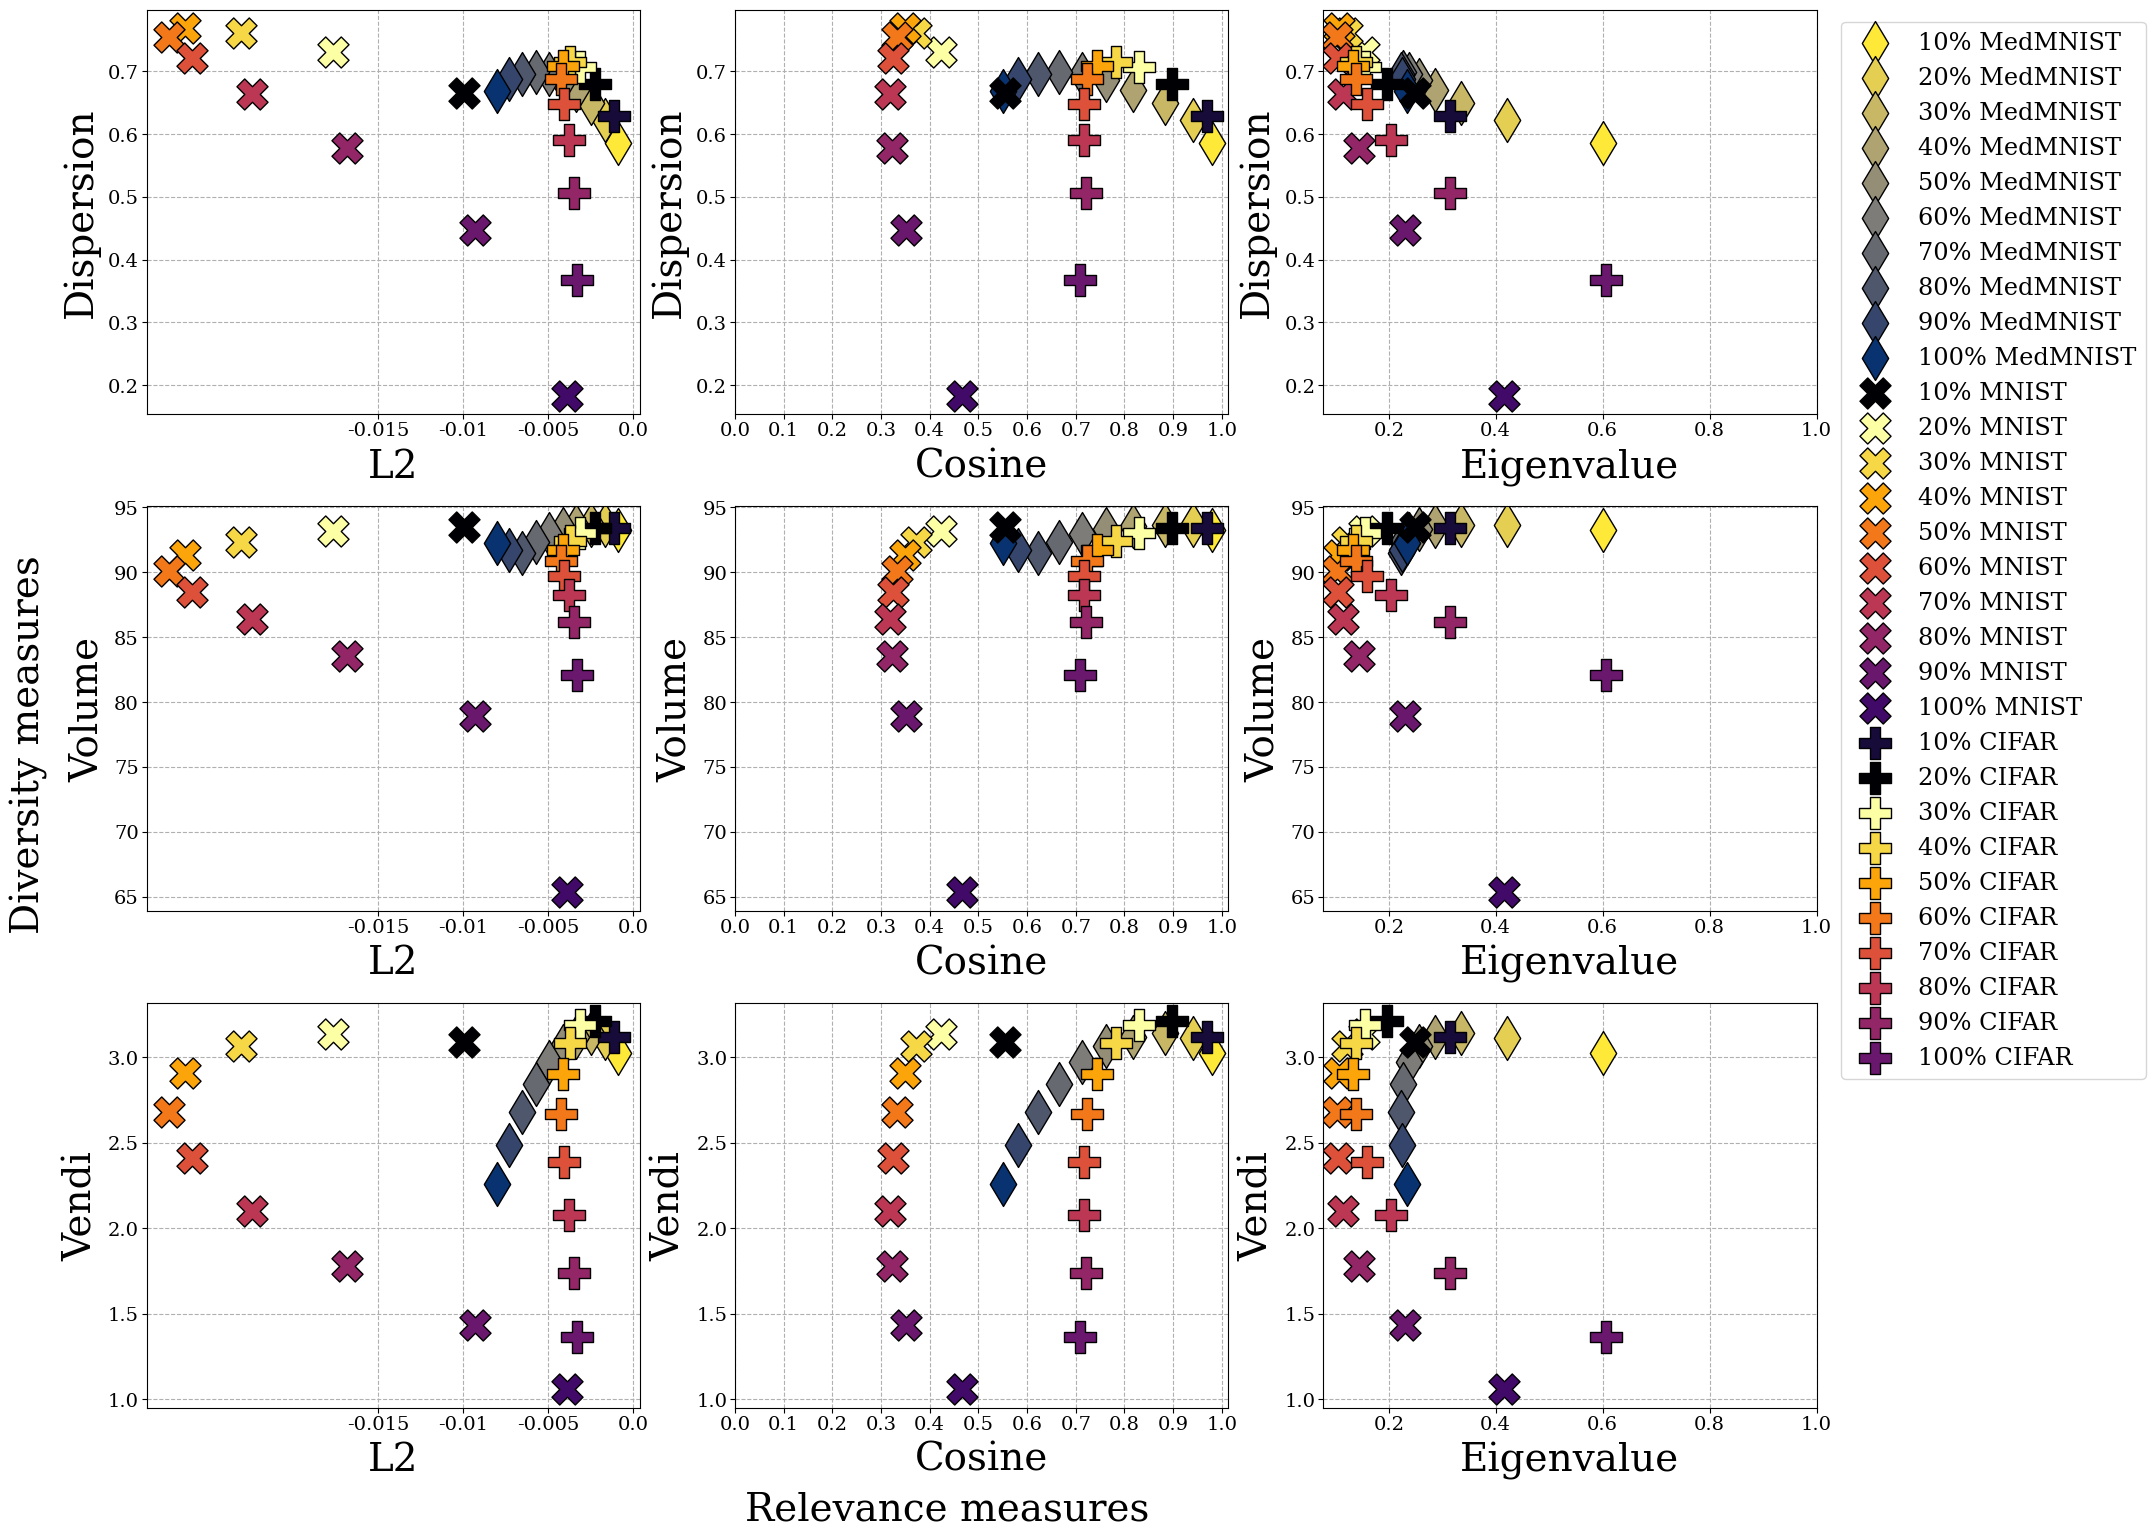

In [198]:
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.2, 1, len(seller_values)))

fontsize = 28
size = 500

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, (k, v) in enumerate(seller_values.items()):
    print(k)

    match k:
        case str(name) if name == buyer.capitalize():
            marker = '*'
            c = 'darkgray'
            s = size + 100
        case str(name) if 'noisy' in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            marker = 'o'
            # c = greens[~j]
            c = viridis[i%num]
            s = size
        case str(name) if name.split()[1] == 'MedMNIST':
            # j = (int(name.split()[0][:-1]) // num) -1
            c = cividis[i%num]
            marker = 'd'
            s = size
        case str(name) if name.split()[1] == 'MNIST':
            # j = (int(name.split()[0][:-1]) // num) -1
            c = plasma[i%num]
            marker = 'X'
            s = size
        case str(name) if 'cifar' in name.lower():
            # j = (int(name.split()[0][:-1]) // num) -1
            c = magma[i%num]
            marker = 'P'
            s = size
        case _:
            print(k)
            raise
            
    scatter_kwargs = dict(color=c, edgecolor="k", s=s, zorder=2, marker=marker)
    # cos = (1 + v['cosine']) - (1 + v['neg_cosine'])
    cos = (v['cosine'])
    ven = v['vendi']
    vol = v['volume'] 
    dis = v["dispersion"] #- v['neg_dispersion']

    axs[0, 0].scatter(v["l2"], dis,  label=k, **scatter_kwargs)
    axs[1, 0].scatter(v["l2"], vol, **scatter_kwargs)
    axs[2, 0].scatter(v["l2"], ven, **scatter_kwargs)
    axs[0, 1].scatter(cos, dis,  **scatter_kwargs)
    axs[1, 1].scatter(cos, vol, **scatter_kwargs)
    axs[2, 1].scatter(cos, ven, **scatter_kwargs)
    axs[0, 2].scatter(v["relevance"], dis, **scatter_kwargs)
    axs[1, 2].scatter(v["relevance"], vol, **scatter_kwargs)
    axs[2, 2].scatter(v["relevance"], ven, **scatter_kwargs)
    
    # plot_kwargs = dict(color=c, )
    # axs[0, 0].plot(v["l2"], dis,  label=k, **plot_kwargs)
    # axs[1, 0].plot(v["l2"], vol, **plot_kwargs)
    # axs[2, 0].plot(v["l2"], ven, **plot_kwargs)
    # axs[0, 1].plot(cos, dis,  **plot_kwargs)
    # axs[1, 1].plot(cos, vol, **plot_kwargs)
    # axs[2, 1].plot(cos, ven, **plot_kwargs)
    # axs[0, 2].plot(v["relevance"], dis, **plot_kwargs)
    # axs[1, 2].plot(v["relevance"], vol, **plot_kwargs)
    # axs[2, 2].plot(v["relevance"], ven, **plot_kwargs)
    
axs[0, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[1, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[2, 0].set_xlabel("L2", fontsize=fontsize, labelpad=6)
axs[0, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[1, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[2, 1].set_xlabel("Cosine", fontsize=fontsize, labelpad=6)
axs[0, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[1, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[2, 2].set_xlabel("Eigenvalue", fontsize=fontsize, labelpad=6)
axs[0, 0].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 1].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[0, 2].set_ylabel("Dispersion", fontsize=fontsize, labelpad=6)
axs[1, 0].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 1].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[1, 2].set_ylabel("Volume", fontsize=fontsize, labelpad=6)
axs[2, 0].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 1].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)
axs[2, 2].set_ylabel("Vendi", fontsize=fontsize, labelpad=6)


axs[0, 0].set_xticks([-0.015, -0.01 , -0.005, 0.0])
axs[1, 0].set_xticks([-0.015, -0.01 , -0.005, 0.0])
axs[2, 0].set_xticks([-0.015, -0.01, -0.005, 0.0])

axs[0, 1].set_xticks([round(x, 1) for x in np.arange(0.0, 1.01, 0.1)])
axs[1, 1].set_xticks([round(x, 1) for x in np.arange(0.0, 1.01, 0.1)])
axs[2, 1].set_xticks([round(x, 1) for x in np.arange(0.0, 1.01, 0.1)])

axs[0, 2].set_xticks([0.2, 0.4, 0.6, 0.8, 1])
axs[1, 2].set_xticks([0.2, 0.4, 0.6, 0.8, 1])
axs[2, 2].set_xticks([0.2, 0.4, 0.6, 0.8, 1])

# axs[0, 1].set_xlim(0.25, 1.01)
# axs[1, 1].set_xlim(0.25, 1.01)
# axs[2, 1].set_xlim(0.25, 1.01)

# axs[0, 1].set_xlim(0.50, 1.01)
# axs[1, 1].set_xlim(0.50, 1.01)
# axs[2, 1].set_xlim(0.50, 1.01)

# axs[0, 1].set_xlim(0.75, 1.01)
# axs[1, 1].set_xlim(0.75, 1.01)
# axs[2, 1].set_xlim(0.75, 1.01)

# axs[0, 1].set_xlim(0.80, 1.01)
# axs[1, 1].set_xlim(0.80, 1.01)
# axs[2, 1].set_xlim(0.80, 1.01)

# axs[0, 2].set_xlim(0.25, 0.90)
# axs[1, 2].set_xlim(0.25, 0.90)
# axs[2, 2].set_xlim(0.25, 0.90)

# axs[0, 2].set_xlim(0.4, 1.00)
# axs[1, 2].set_xlim(0.4, 1.00)
# axs[2, 2].set_xlim(0.4, 1.00)

# axs[0, 0].set_ylim(0.40, 0.800)
# axs[0, 1].set_ylim(0.40, 0.800)
# axs[0, 2].set_ylim(0.40, 0.800)

# axs[1, 0].set_ylim(80, 100)
# axs[1, 1].set_ylim(80, 100)
# axs[1, 2].set_ylim(80, 100)



axs[0, 0].set_xticklabels(axs[0, 0].get_xticks(), fontsize="x-large")
axs[0, 1].set_xticklabels(axs[0, 1].get_xticks(), fontsize="x-large")
axs[0, 2].set_xticklabels(axs[0, 2].get_xticks(), fontsize="x-large")

axs[1, 0].set_xticklabels(axs[1, 0].get_xticks(), fontsize="x-large")
axs[1, 1].set_xticklabels(axs[1, 1].get_xticks(), fontsize="x-large")
axs[1, 2].set_xticklabels(axs[1, 2].get_xticks(), fontsize="x-large")

axs[2, 0].set_xticklabels(axs[2, 0].get_xticks(), fontsize="x-large")
axs[2, 1].set_xticklabels(axs[2, 1].get_xticks(), fontsize="x-large")
axs[2, 2].set_xticklabels(axs[2, 2].get_xticks(), fontsize="x-large")


fig.text(0.5, -0.01, 'Relevance measures', ha='center', va='center', fontsize=fontsize)
fig.text(-0.01, 0.5, 'Diversity measures', ha='center', va='center', fontsize=fontsize, rotation=90)

for ax in axs.flat:
    # ax.set_xlim(0, 1)
    ax.tick_params(axis="both", labelsize=14, pad=2)
    ax.grid(ls='--', zorder=0)
    # ax.set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
    # ax.set_ylabel("Difference", fontsize=fontsize, labelpad=6)
    # ax

# fig.legend(bbox_to_anchor=(0.15, -0.03), loc='upper left', fontsize='xx-large', ncols=4)
fig.legend(bbox_to_anchor=(0.99, 0.99), loc='upper left', fontsize='xx-large', ncols=1)
fig.tight_layout(h_pad=1, w_pad=0)
# plt.savefig(fig_dir / f"{buyer}.eps", bbox_inches='tight')

In [199]:
sev_classes = {
    "pathmnist": [8, 7, 6],
    "dermamnist": [4, 1, 0],
    "bloodmnist": [6, 5, 4],
    "chestmnist": [6, 7],
    "breastmnist": [0],
    "tissuemnist": [2, 5, 6],
    "retinamnist": [1, 2, 3],
    "organamnist": [7, 8, 3, 6],
}

In [200]:
total_classes = {
    k: len(v['label']) for k, v in medmnist.INFO.items()
}
total_classes

{'pathmnist': 9,
 'chestmnist': 14,
 'dermamnist': 7,
 'octmnist': 4,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'breastmnist': 2,
 'bloodmnist': 8,
 'tissuemnist': 8,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'organmnist3d': 11,
 'nodulemnist3d': 2,
 'adrenalmnist3d': 2,
 'fracturemnist3d': 3,
 'vesselmnist3d': 2,
 'synapsemnist3d': 2}

In [201]:
for k, v in medmnist.INFO.items():
    if k in sev_classes:
        print(k.upper(), [v["label"][str(a)] for a in sev_classes[k]])

PATHMNIST ['colorectal adenocarcinoma epithelium', 'cancer-associated stroma', 'normal colon mucosa']
CHESTMNIST ['pneumonia', 'pneumothorax']
DERMAMNIST ['melanoma', 'basal cell carcinoma', 'actinic keratoses and intraepithelial carcinoma']
RETINAMNIST ['1', '2', '3']
BREASTMNIST ['malignant']
BLOODMNIST ['neutrophil', 'monocyte', 'lymphocyte']
TISSUEMNIST ['Glomerular endothelial cells', 'Podocytes', 'Proximal Tubule Segments']
ORGANAMNIST ['lung-left', 'lung-right', 'heart', 'liver']


In [10]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=1, min_samples=0
):
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}

    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        new_index = []
        for c in np.unique(y):
            class_index = np.where(y == c)[0][:min_samples]
            new_index.extend(class_index)

        for k in seller_indexes:
            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes


# sample_dirichlet_by_class(x_test, y_test, min_samples=2)

In [11]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
    n_clusters=None,
):
    if n_clusters is not None:
        M = model(n_clusters=n_clusters )
    else:
        M = model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)


binary_utility = partial(compute_utility, model=partial(LogisticRegression, max_iter=200), utility=partial(f1_score, average="macro"))
multi_utility = partial(compute_utility, model=partial(RandomForestClassifier, n_estimators=10, max_depth=5), utility=partial(f1_score, average="macro"))
cluster_utility = partial(compute_utility, model=partial(KMeans, n_clusters=10, n_init='auto'), utility=lambda true, pred: homogeneity_score(true.squeeze(), pred.squeeze()))


In [202]:

datasets = ["bloodmnist", "dermamnist", 'retinamnist', 'breastmnist', "pathmnist", 'tissuemnist', 'organamnist']

results = defaultdict(dict)
# new_results = defaultdict(dict)
for d in datasets:
    x = clean_med[d]["embeddings"].float()
    y = clean_med[d]["labels"]

    if d == 'breastmnist':
        num_buyer = 50
        num_samples = 250
        print('breast')
    elif d == 'dermamnist':
        num_buyer = 100
        num_samples = 1500
        print('derma')
    elif d == 'pathmnist':
        num_buyer = 100
        num_samples = 1500 
        print('path')
    elif d == 'retinamnist':
        num_buyer = 100
        num_samples = 500 
        print('retina')
    elif d == 'Tissuemnist':
        num_buyer = 1500
        num_samples = 25000 
        print('tissue')
    else:
        num_buyer = 500
        num_samples = 5000
        print('other')
    
    x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.3)
    print(x_dev.shape, x_test.shape)
    
    # cs = torch.tensor([4, 1, 0])
    cs = torch.tensor(sev_classes[d])
    
    if d == 'chestmnist':
        buyer_index = reduce(
            torch.logical_or, 
            torch.chunk(y_test[:, cs], len(cs), dim=1)
        ).flatten()
    else:
        buyer_index = torch.isin(y_test.squeeze(), cs)
        
    x_buyer = x_test[buyer_index][:num_buyer]
    y_buyer = y_test[buyer_index][:num_buyer]
    
    class_bc = []
    vs = []
    bin_us = []
    multi_us = []
    cluster_us = []
    num_corr_class = []
    
    for i, (k, v) in tqdm(
        enumerate(sample_dirichlet_by_class(
            x_dev, y_dev, num_sellers=500, num_samples=num_samples, add_to_alpha=0.2, min_samples=1
        ).items())
    ):
        x_k = x_dev[v]
        y_k = y_dev.squeeze()[v]
    
        bc = np.bincount(y_k, minlength=total_classes[d])
        class_bc.append(bc)
    
        total = 0
        for c in cs:
            total += bc[c]
        num_corr_class.append(total)
    
        v = valuation.get_value(x_buyer, x_k)
        vs.append(v)
    
        bin_u = compute_utility(
            x_k,
            torch.isin(y_k, cs),
            x_test,
            buyer_index,
        )
    
        multi_u = compute_utility(
            x_k,
            y_k,
            x_test,
            y_test,
        )
    
        cluster_u = cluster_utility(
            x_k,
            y_k,
            x_test,
            y_test,
            n_clusters=len(sev_classes[d]),
        )
    
        bin_us.append(bin_u)
        multi_us.append(multi_u)
        cluster_us.append(cluster_u)

        if i % 20 == 0:
            print(k, bc, f'{bin_u:.2f}', f'{multi_u:.2f}', f'{cluster_u:.2f}', {k: round(v_, 2) for k, v_ in v.items()})

    results[d]['class_bc'] = class_bc
    results[d]['vs'] = vs
    results[d]['bin_us'] = bin_us
    results[d]['multi_us'] = multi_us
    results[d]['cluster_us'] = cluster_us
    results[d]['num_corr_class'] = num_corr_class


other
torch.Size([8371, 512]) torch.Size([3588, 512])


0it [00:00, ?it/s]

0 [ 162 1527  502   92   56  595 1081  985] 0.80 0.73 0.06 {'relevance': 0.75, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.19, 'volume': 88.36, 'vendi': 1.99, 'dispersion': 0.62}
20 [ 587 1497    1 1358   18  278 1255    6] 0.78 0.56 0.05 {'relevance': 0.79, 'l2': -0.0, 'cosine': 1.0, 'diversity': 0.2, 'volume': 87.88, 'vendi': 1.99, 'dispersion': 0.6}
40 [ 116  956  523 1201  290   42 1266  606] 0.84 0.78 0.05 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.15, 'volume': 88.34, 'vendi': 1.98, 'dispersion': 0.61}
60 [ 471   15  143 1261   43  395 1612 1060] 0.74 0.73 0.06 {'relevance': 0.84, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.08, 'volume': 88.65, 'vendi': 2.04, 'dispersion': 0.62}
80 [   4  604  146 1389  432  455 1437  533] 0.85 0.74 0.05 {'relevance': 0.85, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.09, 'volume': 88.68, 'vendi': 2.03, 'dispersion': 0.62}
100 [ 595 1525  357  877  571  549  103  423] 0.80 0.84 0.06 {'relevance': 0.74, 'l2': -0.0, 'cosine': 0.99, '

0it [00:00, ?it/s]

0 [  29   75    6    1  126 1255    8] 0.70 0.26 0.04 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.11, 'volume': 74.04, 'vendi': 3.79, 'dispersion': 0.65}
20 [ 121   95   16    1   58 1185   24] 0.68 0.32 0.05 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.12, 'volume': 73.84, 'vendi': 3.75, 'dispersion': 0.65}
40 [ 134   12   79   13   34 1227    1] 0.63 0.23 0.04 {'relevance': 0.81, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.16, 'volume': 73.78, 'vendi': 3.72, 'dispersion': 0.65}
60 [  27    1  248    2    1 1220    1] 0.45 0.20 0.04 {'relevance': 0.81, 'l2': -0.0, 'cosine': 0.95, 'diversity': 0.14, 'volume': 73.69, 'vendi': 3.75, 'dispersion': 0.65}
80 [132  69 169   1 172 956   1] 0.69 0.34 0.04 {'relevance': 0.84, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.12, 'volume': 74.16, 'vendi': 3.74, 'dispersion': 0.66}
100 [   2  131    9    1   23 1333    1] 0.63 0.19 0.04 {'relevance': 0.79, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.13, 'volume': 73.64

0it [00:00, ?it/s]

0 [246  63 138   3  50] 0.65 0.31 0.02 {'relevance': 0.85, 'l2': -0.0, 'cosine': 0.88, 'diversity': 0.09, 'volume': 60.54, 'vendi': 2.38, 'dispersion': 0.58}
20 [294  78  50  77   1] 0.70 0.29 0.01 {'relevance': 0.85, 'l2': -0.0, 'cosine': 0.84, 'diversity': 0.07, 'volume': 60.47, 'vendi': 2.36, 'dispersion': 0.58}
40 [282  71  81  30  36] 0.65 0.31 0.02 {'relevance': 0.84, 'l2': -0.0, 'cosine': 0.87, 'diversity': 0.09, 'volume': 60.46, 'vendi': 2.38, 'dispersion': 0.58}
60 [268  13 145  50  24] 0.68 0.22 0.03 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.84, 'diversity': 0.12, 'volume': 60.13, 'vendi': 2.34, 'dispersion': 0.57}
80 [298  81  41  41  39] 0.59 0.35 0.03 {'relevance': 0.85, 'l2': -0.0, 'cosine': 0.79, 'diversity': 0.09, 'volume': 60.41, 'vendi': 2.33, 'dispersion': 0.58}
100 [300   1 144   5  50] 0.58 0.25 0.04 {'relevance': 0.82, 'l2': -0.0, 'cosine': 0.85, 'diversity': 0.11, 'volume': 59.73, 'vendi': 2.32, 'dispersion': 0.56}
120 [309  41  58  91   1] 0.67 0.30 0.03 {'rel

0it [00:00, ?it/s]

0 [ 58 192] 0.73 0.73 0.00 {'relevance': 0.78, 'l2': -0.0, 'cosine': 0.87, 'diversity': 0.17, 'volume': 51.09, 'vendi': 2.26, 'dispersion': 0.55}
20 [ 93 157] 0.74 0.74 0.00 {'relevance': 0.79, 'l2': -0.0, 'cosine': 0.85, 'diversity': 0.17, 'volume': 51.53, 'vendi': 2.24, 'dispersion': 0.55}
40 [ 83 167] 0.76 0.76 0.00 {'relevance': 0.79, 'l2': -0.0, 'cosine': 0.86, 'diversity': 0.18, 'volume': 50.73, 'vendi': 2.16, 'dispersion': 0.54}
60 [ 37 213] 0.65 0.65 0.00 {'relevance': 0.77, 'l2': -0.0, 'cosine': 0.9, 'diversity': 0.17, 'volume': 50.81, 'vendi': 2.23, 'dispersion': 0.54}
80 [  5 245] 0.43 0.43 0.00 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.88, 'diversity': 0.13, 'volume': 50.02, 'vendi': 2.24, 'dispersion': 0.53}
100 [ 25 225] 0.59 0.59 0.00 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.88, 'diversity': 0.14, 'volume': 51.03, 'vendi': 2.25, 'dispersion': 0.55}
120 [ 84 166] 0.75 0.75 0.00 {'relevance': 0.8, 'l2': -0.0, 'cosine': 0.87, 'diversity': 0.16, 'volume': 50.85, 'vendi': 

0it [00:00, ?it/s]

0 [ 30  18 195   9   3 293  57 554 341] 0.75 0.66 0.11 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.09, 'volume': 70.59, 'vendi': 1.95, 'dispersion': 0.51}
20 [695 113  14   1 304 349  15   1   8] 0.56 0.45 0.21 {'relevance': 0.44, 'l2': -0.01, 'cosine': 0.85, 'diversity': 0.45, 'volume': 70.69, 'vendi': 1.8, 'dispersion': 0.56}
40 [ 16 141   2 648 198   1 103  15 376] 0.74 0.57 0.15 {'relevance': 0.69, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.2, 'volume': 70.18, 'vendi': 1.88, 'dispersion': 0.52}
60 [ 99  22   1 957   1   3 156   1 260] 0.73 0.43 0.15 {'relevance': 0.69, 'l2': -0.0, 'cosine': 0.91, 'diversity': 0.14, 'volume': 68.75, 'vendi': 1.78, 'dispersion': 0.49}
80 [  4  34 876   2  82 174   1 199 128] 0.79 0.55 0.15 {'relevance': 0.75, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.14, 'volume': 70.12, 'vendi': 1.88, 'dispersion': 0.52}
100 [  3   1  11 264 336  21   1  59 804] 0.71 0.50 0.10 {'relevance': 0.81, 'l2': -0.0, 'cosine': 0.95, 'diversity': 0.13, 'vo

0it [00:00, ?it/s]

0 [  21 2335  135   37   33  673  115 1651] 0.52 0.13 0.03 {'relevance': 0.89, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.04, 'volume': 88.14, 'vendi': 2.15, 'dispersion': 0.63}
20 [2016    1    4    3    1    1 2952   22] 0.62 0.14 0.03 {'relevance': 0.9, 'l2': -0.0, 'cosine': 0.98, 'diversity': 0.06, 'volume': 88.4, 'vendi': 2.31, 'dispersion': 0.63}
40 [1228  923   27 2652   43    1   18  108] 0.41 0.16 0.02 {'relevance': 0.75, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.18, 'volume': 87.52, 'vendi': 2.06, 'dispersion': 0.63}
60 [ 457   77    6 2733    1  134 1564   28] 0.63 0.20 0.03 {'relevance': 0.83, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.13, 'volume': 88.28, 'vendi': 2.23, 'dispersion': 0.64}
80 [1214    1  356 1288   81  217 1697  146] 0.67 0.29 0.03 {'relevance': 0.85, 'l2': -0.0, 'cosine': 0.99, 'diversity': 0.08, 'volume': 88.66, 'vendi': 2.28, 'dispersion': 0.65}
100 [4198  144    1  283   18   21  334    1] 0.54 0.18 0.02 {'relevance': 0.79, 'l2': -0.0, 'cosine': 0.97,

0it [00:00, ?it/s]

0 [  76    1    2  135    3  283   10 1867 1010  680  933] 0.86 0.51 0.18 {'relevance': 0.71, 'l2': -0.0, 'cosine': 0.89, 'diversity': 0.2, 'volume': 85.77, 'vendi': 1.73, 'dispersion': 0.58}
20 [ 213  979   35    4  343  987   37  433   46  707 1216] 0.85 0.65 0.17 {'relevance': 0.66, 'l2': -0.0, 'cosine': 0.89, 'diversity': 0.24, 'volume': 83.65, 'vendi': 1.7, 'dispersion': 0.55}
40 [ 311   22   45  623 2637  468    1    1  422  385   85] 0.87 0.50 0.17 {'relevance': 0.62, 'l2': -0.0, 'cosine': 0.89, 'diversity': 0.29, 'volume': 84.73, 'vendi': 1.81, 'dispersion': 0.58}
60 [   4   20    2   61 1143  599 2863    2  213    9   84] 0.92 0.42 0.18 {'relevance': 0.68, 'l2': -0.0, 'cosine': 0.94, 'diversity': 0.22, 'volume': 85.07, 'vendi': 1.77, 'dispersion': 0.57}
80 [ 19 851   3   9 173 876 597 930 773 384 385] 0.97 0.67 0.19 {'relevance': 0.69, 'l2': -0.0, 'cosine': 0.93, 'diversity': 0.22, 'volume': 86.06, 'vendi': 1.75, 'dispersion': 0.59}
100 [  23    7    1    2  965    1  867 1035

In [731]:
np.mean([31, 27, 24])

27.333333333333332

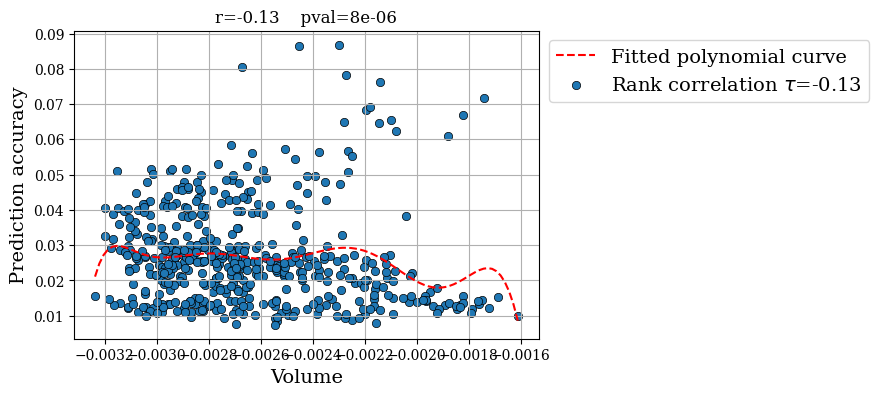

In [756]:
d = "bloodmnist"
d = "dermamnist"
d = 'retinamnist'
# d = "pathmnist"
# d = 'tissuemnist'
# d = 'organamnist'

class_bc = new_results[d]['class_bc']
vs = new_results[d]['vs'] 
bin_us = new_results[d]['bin_us']
multi_us= new_results[d]['multi_us']
cluster_us = new_results[d]['cluster_us']
num_corr_class = new_results[d]['num_corr_class']

_x = [v["l2"] for v in vs]
# _x = [v["cosine"] for v in vs]
# _x = [v["relevance"] for v in vs]
# _x = [v["dispersion"] for v in vs]
# _x = [v["volume"] for v in vs]
# _x = [v["vendi"] for v in vs]
# _x = num_corr_class
# _y = bin_us
# _y = multi_us
_y = cluster_us

coefficients = np.polyfit(_x, _y, 10)# Fit the polynomial (degree 2)
polynomial = np.poly1d(coefficients)# Create a polynomial function with the fitted coefficients
x_fit = np.linspace(min(_x), max(_x), 100)# Generate x values for plotting the polynomial fit
y_fit = polynomial(x_fit)
# r = pearsonr(_x, _y)
r = kendalltau(_x, _y)
plt.figure(figsize=(6, 4))
plt.plot(x_fit, y_fit, color='red', label='Fitted polynomial curve', ls='--')
plt.scatter(
    _x, _y, 
    label = fr"Rank correlation $\tau$={round(r.statistic, 2)}",
    edgecolors='k',
    lw=0.5,
)
plt.title(f"r={round(r.statistic, 2)}    pval={round(r.pvalue, 6)}")
# plt.title(fr"$\tau$={round(r.statistic, 2)}", fontsize=14)
plt.grid()
# plt.xlabel('Data measurement', fontsize=14)
# plt.xlabel('Relevance', fontsize=14)
plt.xlabel('Volume', fontsize=14)
# plt.xlabel('Number of data points with relevant labels', fontsize=14)
plt.ylabel('Prediction accuracy', fontsize=14)
# plt.ylim(0.0, 1)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1))
# plt.savefig(fig_dir / f"{d}_correlation_multi.eps", bbox_inches='tight')
# plt.savefig(fig_dir / f"{d}_correlation_cluster.eps", bbox_inches='tight')

In [113]:
def baseline_valuation(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    num_classes,
    random_state=0,
    model=LogisticRegression,
    valuation_method=KNNShapley,
):
    fetcher = DataFetcher.from_data_splits(
        x_train, y_train, x_val, y_val, x_test, y_test, one_hot=False
    )

    pred_model = ClassifierSkLearnWrapper(
        LogisticRegression,
        num_classes=num_classes,
    )

    values = (
        valuation_method(random_state=random_state)
        .train(fetcher=fetcher, pred_model=pred_model)
        .data_values
    )
    return values

In [26]:
baseline_valuation(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    num_classes,
)

# 